In [43]:
import uproot
import awkward as ak
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from decayvertex.process_data import LorentzVectorArray, ThreeVectorArray

file = uproot.open("data/data.root")
tree = file["NOMINAL"]
tree.keys()

['charged_pion_truth_p4',
 'neutral_pion_truth_p4',
 'tau_vis_truth_p4',
 'muon_truth_p4',
 'tau_lep_truth_p4',
 'tau_had_truth_p4',
 'truth_lep_decayVertex_v3',
 'est_lep_decayVertex_v3',
 'truth_primaryVertex_v3',
 'lep_impactParameter']

In [44]:
muon_p4 = LorentzVectorArray(tree['muon_truth_p4'].array())
lep_impact_parameter = ThreeVectorArray(tree['lep_impactParameter'].array())
primary_vertex = ThreeVectorArray(tree['truth_primaryVertex_v3'].array())

inputs = ak.concatenate([
    muon_p4.pt[:, None],
    muon_p4.eta[:, None],
    muon_p4.phi[:, None],
    muon_p4.m[:, None],
    lep_impact_parameter.x[:, None],
    lep_impact_parameter.y[:, None],
    lep_impact_parameter.z[:, None],
    primary_vertex.x[:, None],
    primary_vertex.y[:, None],
    primary_vertex.z[:, None],
], axis=1)
inputs

<Array [[29.1, -0.878, ..., -2.66e-14], ...] type='345162 * 10 * float64'>

In [45]:
truth_decay_vertex = ThreeVectorArray(tree['truth_lep_decayVertex_v3'].array())

labels = ak.concatenate([
    truth_decay_vertex.x[:, None],
    truth_decay_vertex.y[:, None],
    truth_decay_vertex.z[:, None],
], axis=1)
labels

<Array [[-0.345, -0.511, -0.624], ..., [1.15, ...]] type='345162 * 3 * float64'>

In [46]:
inputs = ak.to_numpy(inputs)
labels = ak.to_numpy(labels)

class DecayDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.from_numpy(inputs).float()
        self.labels = torch.from_numpy(labels).float()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

dataset = DecayDataset(inputs, labels)
train_indices, val_indices = train_test_split(
    range(len(dataset)), test_size=0.2, random_state=42
)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

In [54]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Build NN and train

In [55]:
class DecayNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DecayNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [56]:
input_size = 10
hidden_size = 64
output_size = 3

model = DecayNet(input_size, hidden_size, output_size)
model

DecayNet(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [57]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 20

### Training loop

In [58]:
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for inputs, labels in train_loader:
        # Zero the gradient buffers
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
    # Compute average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Step 4: Validate the Model
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)
    
    # Print training and validation loss
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}")

Epoch [1/20], Training Loss: 18.6296, Validation Loss: 18.0469
Epoch [2/20], Training Loss: 17.7131, Validation Loss: 18.4304
Epoch [3/20], Training Loss: 17.5403, Validation Loss: 17.6287
Epoch [4/20], Training Loss: 17.2086, Validation Loss: 16.8953
Epoch [5/20], Training Loss: 14.7106, Validation Loss: 12.2523
Epoch [6/20], Training Loss: 11.4259, Validation Loss: 11.7350
Epoch [7/20], Training Loss: 9.8685, Validation Loss: 9.3057
Epoch [8/20], Training Loss: 9.1691, Validation Loss: 8.9325
Epoch [9/20], Training Loss: 8.1826, Validation Loss: 7.6809
Epoch [10/20], Training Loss: 6.6816, Validation Loss: 7.1730
Epoch [11/20], Training Loss: 6.3717, Validation Loss: 5.6776
Epoch [12/20], Training Loss: 6.1437, Validation Loss: 5.5433
Epoch [13/20], Training Loss: 6.1944, Validation Loss: 6.1309
Epoch [14/20], Training Loss: 6.0253, Validation Loss: 5.9105
Epoch [15/20], Training Loss: 6.1220, Validation Loss: 5.5710
Epoch [16/20], Training Loss: 5.8843, Validation Loss: 6.3784
Epoch

## Plot Results

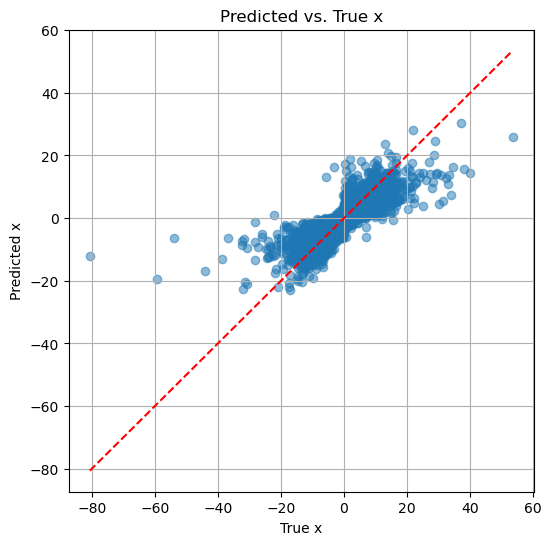

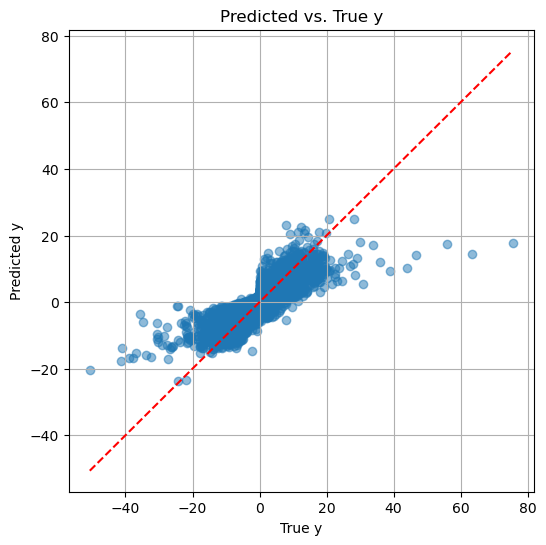

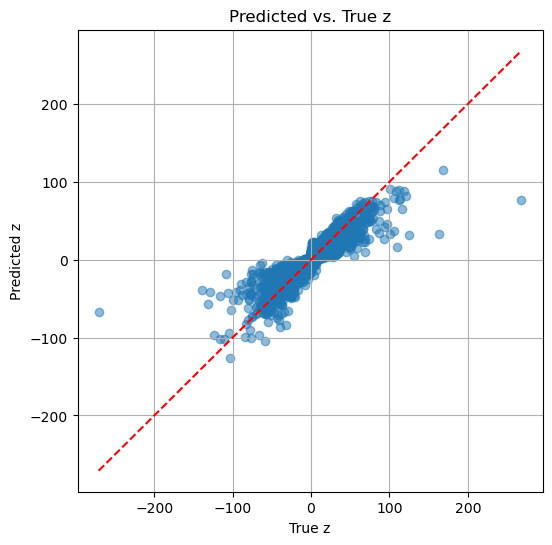

In [59]:
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        # Move data to the appropriate device (if using GPU)
        # inputs = inputs.to(device)
        # labels = labels.to(device)
        
        # Get model predictions
        outputs = model(inputs)
        
        # Store predictions and true labels
        predictions.append(outputs.cpu())
        true_labels.append(labels.cpu())

# Concatenate all batches
predictions = torch.cat(predictions).numpy()
true_labels = torch.cat(true_labels).numpy()

components = ['x', 'y', 'z']
for i in range(3):
    plt.figure(figsize=(6, 6))
    plt.scatter(true_labels[:, i], predictions[:, i], alpha=0.5)
    plt.plot(
        [true_labels[:, i].min(), true_labels[:, i].max()],
        [true_labels[:, i].min(), true_labels[:, i].max()],
        'r--'
    )
    plt.xlabel(f"True {components[i]}")
    plt.ylabel(f"Predicted {components[i]}")
    plt.title(f"Predicted vs. True {components[i]}")
    plt.grid(True)
    plt.show()

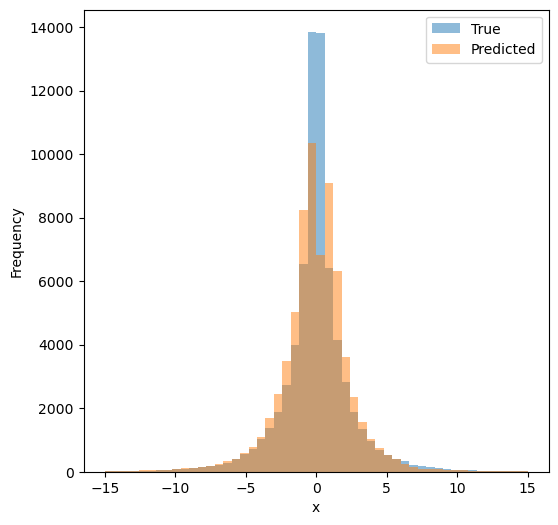

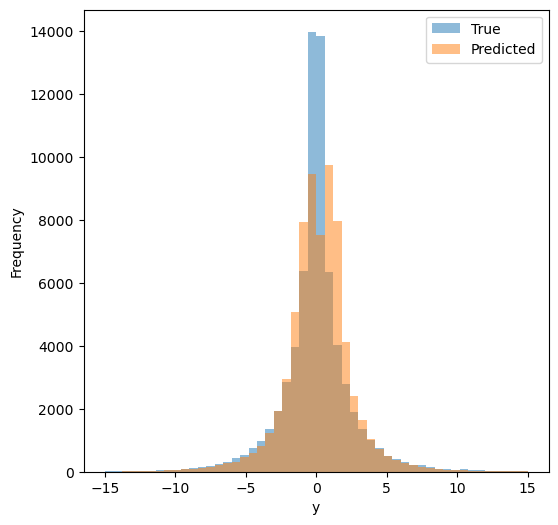

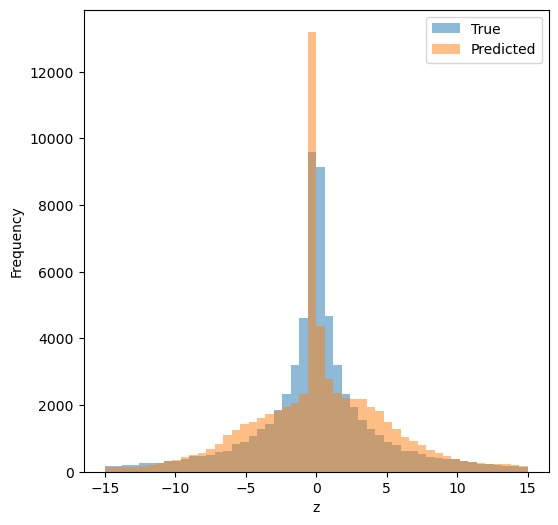

In [64]:
from decayvertex.plotting import plot_multiple_histograms

for i in range(3):
    plot_multiple_histograms(
        [true_labels[:, i], predictions[:, i]],
        range=(-15, 15),
        labels=['True', 'Predicted'],
        bins=50,
        xlabel=f"{components[i]}",
        ylabel="Frequency",
    )